
Example 2: 1st-level Analysis

In this example, we will take the preprocessed output from the first example and run for each subject a 1st-level analysis. For this we need to do the following steps:

    Extract onset times of stimuli from TVA file
    Specify the model (TR, high pass filter, onset times, etc.)
    Specify contrasts to compute
    Estimate contrasts

In the previous example, we used two different smoothing kernels of fwhm=4 and fwhm=8. Therefore, let us also run the 1st-level analysis for those two versions.

So, let's begin!


In [1]:
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

200728-01:31:18,389 nipype.utils WARNING:
	 A newer version (1.5.0) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


In [2]:
experiment_dir = '/home/neuro/nipype_tutorial/ds000114'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# TR of functional images
with open('/home/neuro/nipype_tutorial/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing withds used during preprocessing
fwhm = [4, 8]

In [3]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")


Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had three different conditions in the fingerfootlips task in this dataset:

    finger
    foot
    lips

Therefore, we could create the following contrasts (seven T-contrasts and two F-contrasts):


In [4]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]


Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called subjectinfo.

To recap, let's see what we have in the TSV file for each run:


In [5]:
!cat /home/neuro/nipype_tutorial/ds000114/task-fingerfootlips_events.tsv

onset	duration	weight	trial_type
10	15.0	1	Finger
40	15.0	1	Foot
70	15.0	1	Lips
100	15.0	1	Finger
130	15.0	1	Foot
160	15.0	1	Lips
190	15.0	1	Finger
220	15.0	1	Foot
250	15.0	1	Lips
280	15.0	1	Finger
310	15.0	1	Foot
340	15.0	1	Lips
370	15.0	1	Finger
400	15.0	1	Foot
430	15.0	1	Lips


In [6]:
import pandas as pd
trialinfo = pd.read_table('/home/neuro/nipype_tutorial/ds000114/task-fingerfootlips_events.tsv')
trialinfo

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot
5,160,15.0,1,Lips
6,190,15.0,1,Finger
7,220,15.0,1,Foot
8,250,15.0,1,Lips
9,280,15.0,1,Finger


And finally we need to separate the onsets of the three conditions, i.e. group by trial_type. This can be done as follows:

In [7]:
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

('Finger',     onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger)

('Foot',     onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot)

('Lips',     onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips)



In [8]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch

    trialinfo = pd.read_table('/home/neuro/nipype_tutorial/ds000114/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')


Specify input & output stream

Specify where the input data can be found & where and how to save the output data.


In [9]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                         'fwhm-{fwhm_id}_ssub-{subject_id}_ses-test_task-{task_id}_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                             'sub-{subject_id}_ses-test_task-{task_id}_bold.par'),
             'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                             'art.sub-{subject_id}_ses-test_task-{task_id}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'fingerfootlips'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions


Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.


In [10]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

200728-01:32:00,126 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


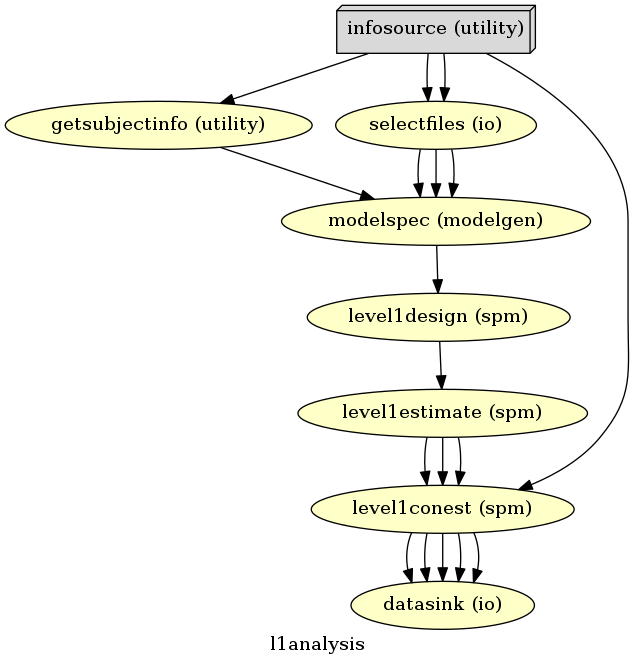

In [11]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

In [12]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 8})

200727-08:28:07,396 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
200727-08:28:07,480 nipype.workflow INFO:
	 Running in parallel.
200727-08:28:07,485 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 40 jobs ready. Free memory (GB): 28.16/28.16, Free processors: 8/8.
200727-08:28:07,538 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_10/selectfiles".200727-08:28:07,538 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_09/getsubjectinfo".200727-08:28:07,539 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_09/getsubjectinfo".

200727-08:28:07,539 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in 

200727-08:28:11,535 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 34 jobs ready. Free memory (GB): 28.16/28.16, Free processors: 8/8.
200727-08:28:11,578 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_10/level1design".

200727-08:28:11,579 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_10/level1design".200727-08:28:11,579 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_09/level1design".200727-08:28:11,579 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_09/level1design".
200727-08:28:11,580 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/ho

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_08/modelspec/art.sub-08_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_08/modelspec/art.sub-08_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


200727-08:28:11,615 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
200727-08:28:11,617 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".200727-08:28:11,611 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")200727-08:28:11,617 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")

200727-08:28:11,610 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
200727-08:28:11,626 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
200727-08:28:11,631 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")

200727-08:28:13,488 nipype.workflow INFO:
	 [Job 30] Completed (l1analysis.modelspec).
200727-08:28:13,490 nipype.workflow INFO:
	 [Job 37] Completed (l1analysis.modelspec).
200727-08:28:13,491 nipype.workflow INFO:
	 [Job 42] Completed (l1analysis.getsubjectinfo).
2007

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_07/modelspec/art.sub-07_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


200727-08:28:13,549 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
200727-08:28:13,564 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
200727-08:28:13,565 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")200727-08:28:13,566 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
200727-08:28:13,568 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")

200727-08:28:15,490 nipype.workflow INFO:
	 [Job 44] Completed (l1analysis.modelspec).
200727-08:28:15,492 nipype.workflow INFO:
	 [Job 49] Completed (l1analysis.getsubjectinfo).
200727-08:28:15,494 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 26 jobs ready. Free memory (GB): 26.96/28.16, Free processors: 2/8.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
   

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_07/modelspec/art.sub-07_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


200727-08:28:17,581 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
200727-08:28:19,495 nipype.workflow INFO:
	 [Job 51] Completed (l1analysis.modelspec).
200727-08:28:19,498 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 25 jobs ready. Free memory (GB): 26.76/28.16, Free processors: 1/8.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
200727-08:28:19,547 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_07/level1design".
200727-08:28:19,586 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1

	 [Node] Finished "l1analysis.level1estimate".
200727-08:28:35,93 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
200727-08:28:35,351 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
200727-08:28:35,511 nipype.workflow INFO:
	 [Job 4] Completed (l1analysis.level1estimate).
200727-08:28:35,513 nipype.workflow INFO:
	 [Job 11] Completed (l1analysis.level1estimate).
200727-08:28:35,514 nipype.workflow INFO:
	 [Job 18] Completed (l1analysis.level1estimate).
200727-08:28:35,516 nipype.workflow INFO:
	 [Job 25] Completed (l1analysis.level1estimate).
200727-08:28:35,521 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 28 jobs ready. Free memory (GB): 27.36/28.16, Free processors: 4/8.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
200727-08:28:35,573 

	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
200727-08:28:45,595 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")200727-08:28:45,594 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")

200727-08:28:45,596 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_10/SPM.mat -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-10/fwhm-8/SPM.mat
200727-08:28:45,598 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_10/SPM.mat -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-10/fwhm-4/SPM.mat200727-08:28:45,599 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_10/spmT_0001.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-10/fwhm-8/spmT_0001.nii
200727-08:28:45,600 nipype.interface INFO:
	 sub: /home/neuro/nip

	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_10/ess_0009.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-10/fwhm-8/ess_0009.nii200727-08:28:45,677 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_09/con_0002.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-09/fwhm-8/con_0002.nii

200727-08:28:45,678 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_10/spmF_0008.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-10/fwhm-8/spmF_0008.nii
200727-08:28:45,672 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_10/ess_0009.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-10/fwhm-4/ess_0009.nii200727-08:28:45,679 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_09/

	 Storing result file without outputs
200727-08:28:47,599 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".200727-08:28:47,597 nipype.workflow WARNING:
	 [Node] Error on "l1analysis.selectfiles" (/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_06/selectfiles)


200727-08:28:47,601 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_08/spmT_0001.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-08/fwhm-8/spmT_0001.nii
200727-08:28:47,603 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_08/spmT_0002.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-08/fwhm-8/spmT_0002.nii
200727-08:28:47,605 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_08/spmT_0003.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-08/fwhm-8/spmT_0003.

200727-08:28:49,575 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_08/datasink".200727-08:28:49,575 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_06/modelspec".200727-08:28:49,575 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_05/getsubjectinfo".200727-08:28:49,576 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_05/selectfiles".

200727-08:28:49,576 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_05/getsubjectinfo".

200727-08:28:49,578 nipype.workflow INFO:
	 [Node] Set

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_06/modelspec/art.sub-06_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


200727-08:28:49,601 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
200727-08:28:49,601 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_08/SPM.mat -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-08/fwhm-4/SPM.mat
200727-08:28:49,604 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_08/spmT_0001.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-08/fwhm-4/spmT_0001.nii
200727-08:28:49,610 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".200727-08:28:49,606 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_08/spmT_0002.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-08/fwhm-4/spmT_0002.nii

200727-08:28:49,612 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_08/spmT_0003.nii -> /h

	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
200727-08:28:51,596 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
200727-08:28:51,597 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
200727-08:28:51,600 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_07/SPM.mat -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-07/fwhm-4/SPM.mat
200727-08:28:51,602 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_07/spmT_0001.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-07/fwhm-4/spmT_0001.nii
200727-08:28:51,603 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")200727-08:28:51,604 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_07/spm

200727-08:28:55,538 nipype.workflow INFO:
	 [Job 105] Completed (l1analysis.getsubjectinfo).
200727-08:28:55,541 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 27.56/28.16, Free processors: 5/8.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
200727-08:28:55,581 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_04/level1design".200727-08:28:55,581 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_04/modelspec".200727-08:28:55,582 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_03/selectfiles".200727-08:28:

200727-08:29:11,611 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_02/level1estimate".200727-08:29:11,611 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_8_subject_id_06/level1conest".

200727-08:29:11,630 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
200727-08:29:11,640 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
200727-08:29:13,545 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
200727-08:29:13,550 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 2 jobs ready. Free memory (GB): 26.56/28.16, Free processors: 0/8.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1con

	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_05/spmT_0004.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-05/fwhm-8/spmT_0004.nii
200727-08:29:25,643 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_05/spmT_0005.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-05/fwhm-8/spmT_0005.nii
200727-08:29:25,644 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_05/spmT_0006.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-05/fwhm-8/spmT_0006.nii
200727-08:29:25,646 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")200727-08:29:25,632 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_05/SPM.mat -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-05/fwhm-4/SPM.mat200727-08:29:2

	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_05/spmT_0005.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-05/fwhm-4/spmT_0005.nii200727-08:29:25,684 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_04/con_0003.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-04/fwhm-8/con_0003.nii
200727-08:29:25,686 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_04/con_0004.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-04/fwhm-8/con_0004.nii
200727-08:29:25,687 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_04/con_0005.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-04/fwhm-8/con_0005.nii
200727-08:29:25,689 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_04/

	 [Node] Setting-up "l1analysis.modelspec" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_01/modelspec".200727-08:29:27,617 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/nipype_tutorial/ds000114/workingdir/l1analysis/_fwhm_id_4_subject_id_04/datasink".

200727-08:29:27,623 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
200727-08:29:27,626 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
200727-08:29:27,627 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_04/SPM.mat -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-04/fwhm-4/SPM.mat
200727-08:29:27,629 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_04/spmT_0001.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-04/fwhm-4/spmT_0001.nii
2007

	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_02/spmF_0009.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-02/fwhm-4/spmF_0009.nii
200727-08:29:33,635 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_02/con_0001.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-02/fwhm-4/con_0001.nii
200727-08:29:33,637 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_02/con_0002.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-02/fwhm-4/con_0002.nii
200727-08:29:33,643 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_02/con_0003.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-02/fwhm-4/con_0003.nii
200727-08:29:33,644 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_4_subject_id_02

	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_01/con_0006.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-8/con_0006.nii
200727-08:29:37,649 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_01/con_0007.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-8/con_0007.nii
200727-08:29:37,651 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_01/ess_0008.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-8/ess_0008.nii
200727-08:29:37,653 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_01/ess_0009.nii -> /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-8/ess_0009.nii
200727-08:29:37,655 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/_fwhm_id_8_subject_id_01/s

RuntimeError: Workflow did not execute cleanly. Check log for details

In [12]:
!tree /home/neuro/nipype_tutorial/ds000114/datasink/1stLevel

/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel
├── sub-01
│   ├── fwhm-4
│   │   ├── con_0001.nii
│   │   ├── con_0002.nii
│   │   ├── con_0003.nii
│   │   ├── con_0004.nii
│   │   ├── con_0005.nii
│   │   ├── con_0006.nii
│   │   ├── con_0007.nii
│   │   ├── ess_0008.nii
│   │   ├── ess_0009.nii
│   │   ├── spmF_0008.nii
│   │   ├── spmF_0009.nii
│   │   ├── SPM.mat
│   │   ├── spmT_0001.nii
│   │   ├── spmT_0002.nii
│   │   ├── spmT_0003.nii
│   │   ├── spmT_0004.nii
│   │   ├── spmT_0005.nii
│   │   ├── spmT_0006.nii
│   │   └── spmT_0007.nii
│   └── fwhm-8
│       ├── con_0001.nii
│       ├── con_0002.nii
│       ├── con_0003.nii
│       ├── con_0004.nii
│       ├── con_0005.nii
│       ├── con_0006.nii
│       ├── con_0007.nii
│       ├── ess_0008.nii
│       ├── ess_0009.nii
│       ├── spmF_0008.nii
│       ├── spmF_0009.nii
│       ├── SPM.mat
│       ├── spmT_0001.nii
│       ├── spmT_0002.nii
│       ├── spmT_0003.nii
│       ├── spmT_0004.nii
│       ├── spmT_0005.ni


Visualize results

Let's look at the contrasts of one subject that we've just computed. First, let's see what the difference of smoothing is for the contrast average


In [13]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = '/home/neuro/nipype_tutorial/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_preproc.nii.gz'

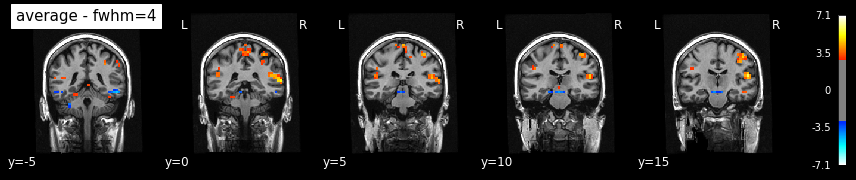

In [16]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-4/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

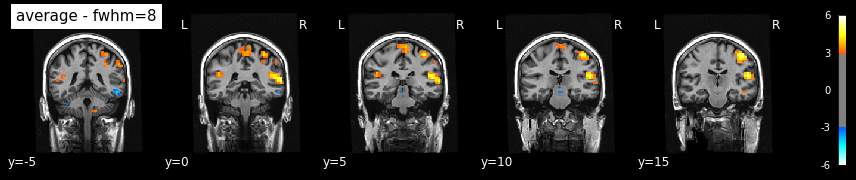

In [17]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-8/spmT_0001.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

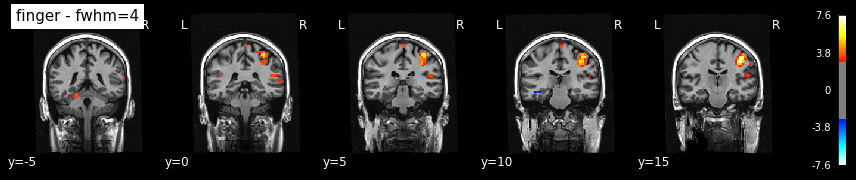

In [20]:


plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-4/spmT_0002.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);



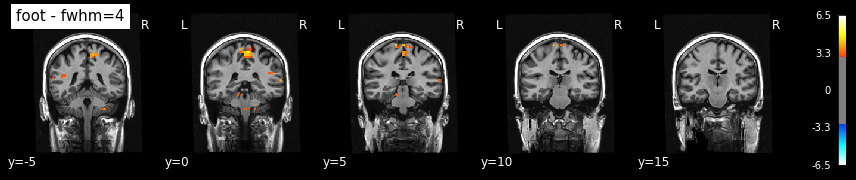

In [21]:


plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-4/spmT_0003.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);



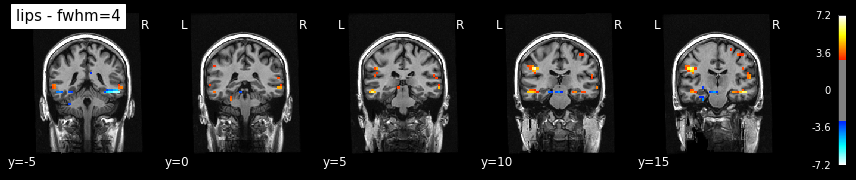

In [22]:


plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-4/spmT_0004.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);





We can also check three additional contrasts Finger > others, Foot > others and Lips > others.


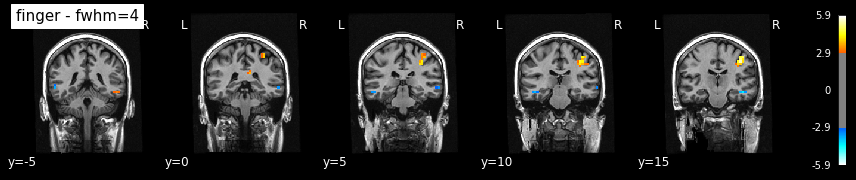

In [23]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-4/spmT_0005.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

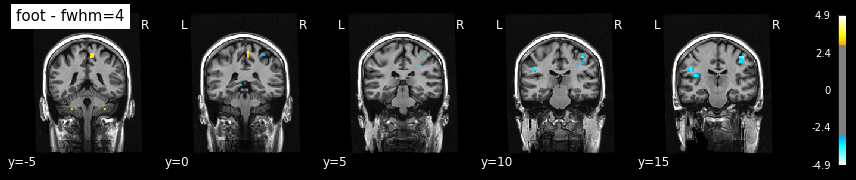

In [24]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-4/spmT_0006.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

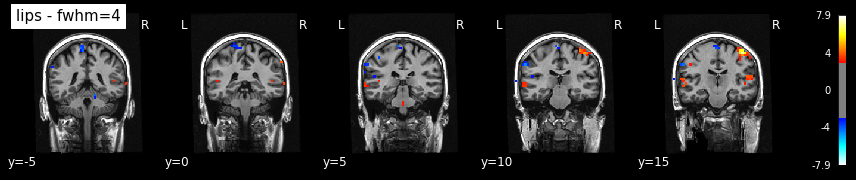

In [25]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-02/fwhm-4/spmT_0007.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);


Special case

There is something special with the Finger contrast in all subjects. So let's take a look at all of them.


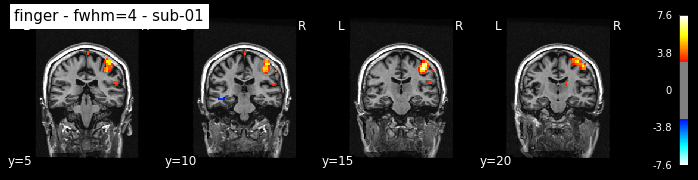

In [26]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-01/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-01',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

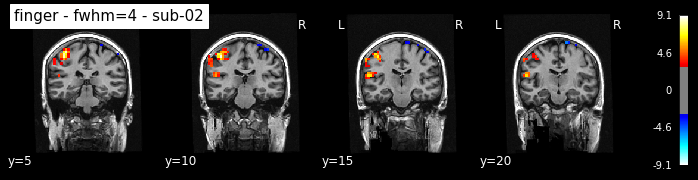

In [27]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-02/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-02',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

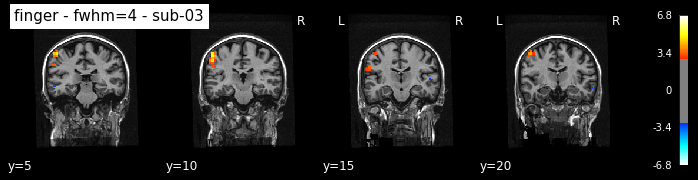

In [28]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-03/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-03',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-03/anat/sub-03_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);


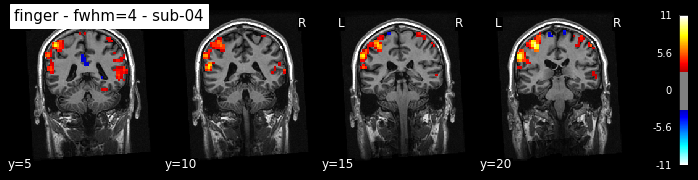

In [29]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-04/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-04',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-04/anat/sub-04_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

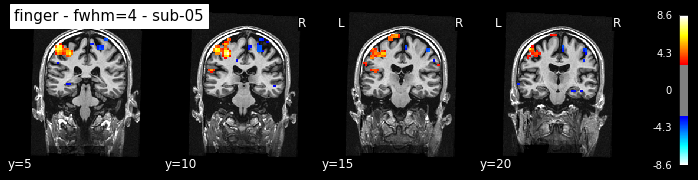

In [30]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-05/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-05',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-05/anat/sub-05_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

In [31]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-06/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-06',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-06/anat/sub-06_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

ValueError: File not found: '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-06/fwhm-4/spmT_0002.nii'

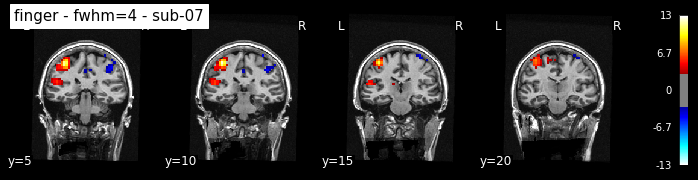

In [32]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-07/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-07',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-07/anat/sub-07_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);


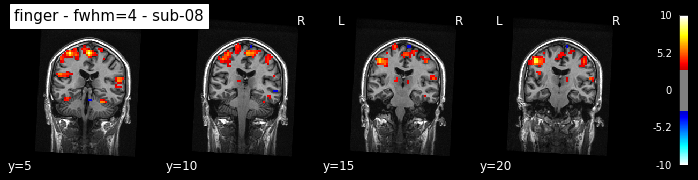

In [33]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-08/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-08',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-08/anat/sub-08_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

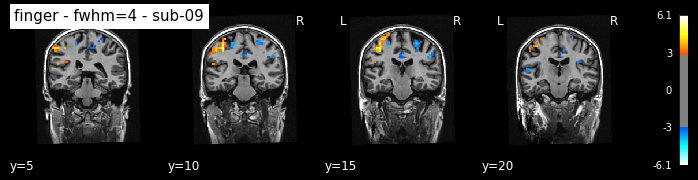

In [34]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-09/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-09',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-09/anat/sub-09_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

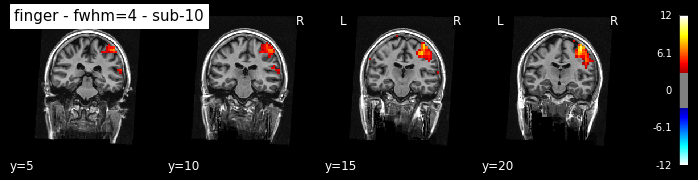

In [35]:
plot_stat_map(
    '/home/neuro/nipype_tutorial/ds000114/datasink/1stLevel/sub-10/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-10',
    bg_img='/data/ds000114/derivatives/fmriprep/sub-10/anat/sub-10_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);